# Data and Library Imports


In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 13.5 MB/s eta 0:00:00


In [2]:
from IPython import get_ipython
from IPython.display import display

In [134]:
import rasterio
from rasterio.enums import Resampling
from rasterio.features import rasterize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import folium.plugins
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import geopandas as gpd
from sklearn.model_selection import train_test_split

In [135]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd drive/MyDrive/ENGO_645/ENGO_645_Project_W2025/

/content/drive/MyDrive/ENGO_645/ENGO_645_Project_W2025


#Full Prediction

In [21]:
tif_files_and_Geophys = [
    'Data/Soil_Geochem/Soil_IDW_Ag/Soil_IDW_Ag.tif',  #Silver
    'Data/Soil_Geochem/Soil_IDW_As/Soil_IDW_As.tif',  #Arsenic
    'Data/Soil_Geochem/Soil_IDW_Al/Soil_IDW_Al.tif',  #Aluminum
    'Data/Soil_Geochem/Soil_IDW_Co/Soil_IDW_Co.tif',  #Cobalt
    'Data/Soil_Geochem/Soil_IDW_Bi/Soil_IDW_Bi.tif',  #Bismuth
    'Data/Soil_Geochem/Soil_IDW_Cu/Soil_IDW_Cu.tif',  #Copper
    'Data/Soil_Geochem/Soil_IDW_Au/Soil_IDW_Au.tif',  #Gold
    'Data/Soil_Geochem/Soil_IDW_Zn/Soil_IDW_Zn.tif',  #Zinc
    'Data/Soil_Geochem/Soil_IDW_Pb/Soil_IDW_Pb.tif',  #Lead
    'Data/Soil_Geochem/Soil_IDW_Ni/Soil_IDW_Ni.tif',  #Nickel
    'Data/Soil_Geochem/Soil_IDW_Mo/Soil_IDW_Mo.tif',  #Molybdenum
    'Data/Soil_Geochem/Soil_IDW_W/Soil_IDW_W.tif',    #Tungsten
    'Data/Soil_Geochem/Soil_IDW_Hg/Soil_IDW_Hg.tif',  #Mercury
    'Data/Soil_Geochem/Soil_IDW_Sn/Soil_IDW_Sn.tif',  #Tin
    'Data/Soil_Geochem/Soil_IDW_Sb/Soil_IDW_Sb.tif',  #Antimony
    'Data/Soil_Geochem/Soil_IDW_Te/Soil_IDW_Te.tif',  #Tellurium
    'Data/Geophysical_Anomaly/GeoPhysAnomaly_DONE.tif'
]

#stack rasters
rasters = []
for tif in tif_files_and_Geophys:
    with rasterio.open(tif) as src:
        array = src.read(1)  #first band
        array = (array - np.min(array)) / (np.max(array) - np.min(array))  #Normalize 0-1
        rasters.append(array)

#Convert list to NumPy array
cnn_input = np.stack(rasters, axis=-1)

print("CNN Input Shape:", cnn_input.shape) #height width of raster and number of minerals

(351, 299)
(351, 299)
(351, 299)
(351, 299)
(351, 299)
(351, 299)
(351, 299)
(351, 299)
(351, 299)
(351, 299)
(351, 299)
(351, 299)
(351, 299)
(351, 299)
(351, 299)
(351, 299)
(351, 299)
CNN Input Shape: (351, 299, 17)


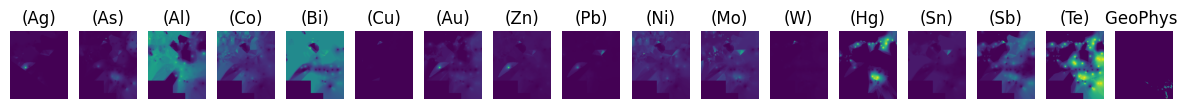

In [23]:
fig, axes = plt.subplots(1, len(tif_files_and_Geophys), figsize=(15, 5))
titles = ["(Ag)", "(As)", "(Al)", "(Co)", "(Bi)", "(Cu)", "(Au)", "(Zn)", "(Pb)", "(Ni)", "(Mo)", "(W)", "(Hg)", "(Sn)", "(Sb)", "(Te)", "GeoPhys "]

for i, ax in enumerate(axes):
    ax.imshow(cnn_input[:, :, i], cmap='viridis')
    ax.set_title(titles[i])
    ax.axis("off")

plt.show()

Gold Mine Labels Shape: (351, 299)


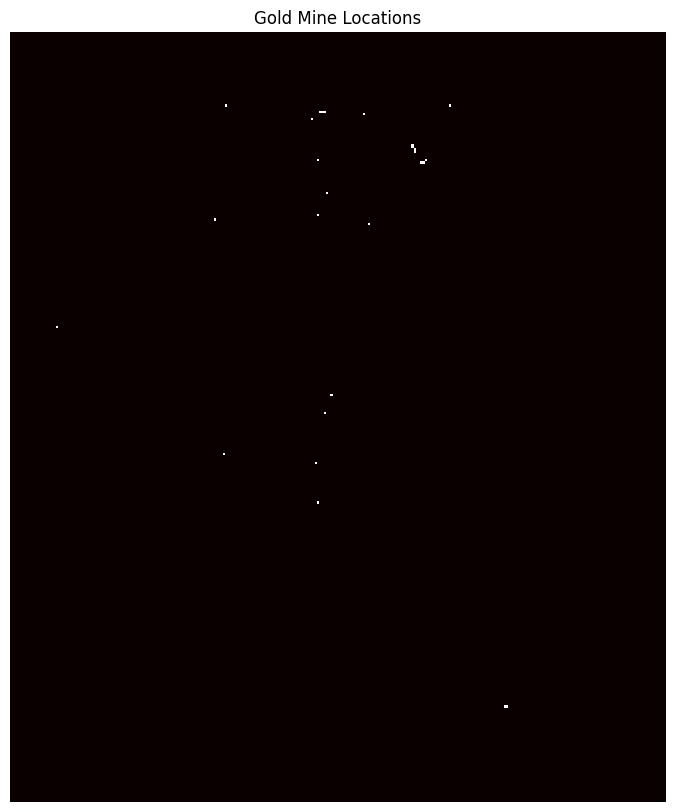

In [24]:
#setting label or target of model
with rasterio.open("Data/Mines/Gold_Mine_Locations_Raster.tif") as src:
    gold_mines_labels = src.read(1)
    print("Gold Mine Labels Shape:", gold_mines_labels.shape)
plt.figure(figsize=(10, 10))
plt.imshow(gold_mines_labels, cmap="hot", interpolation="nearest")
plt.title("Gold Mine Locations")
plt.axis("off")
plt.show()

In [25]:
num_rasters = len(tif_files_and_Geophys)
raster_data = []

# Flatten each raster and append to the list
for i in range(num_rasters):
    with rasterio.open(tif_files_and_Geophys[i]) as src:
        data = src.read(1).flatten()
        raster_data.append(data)

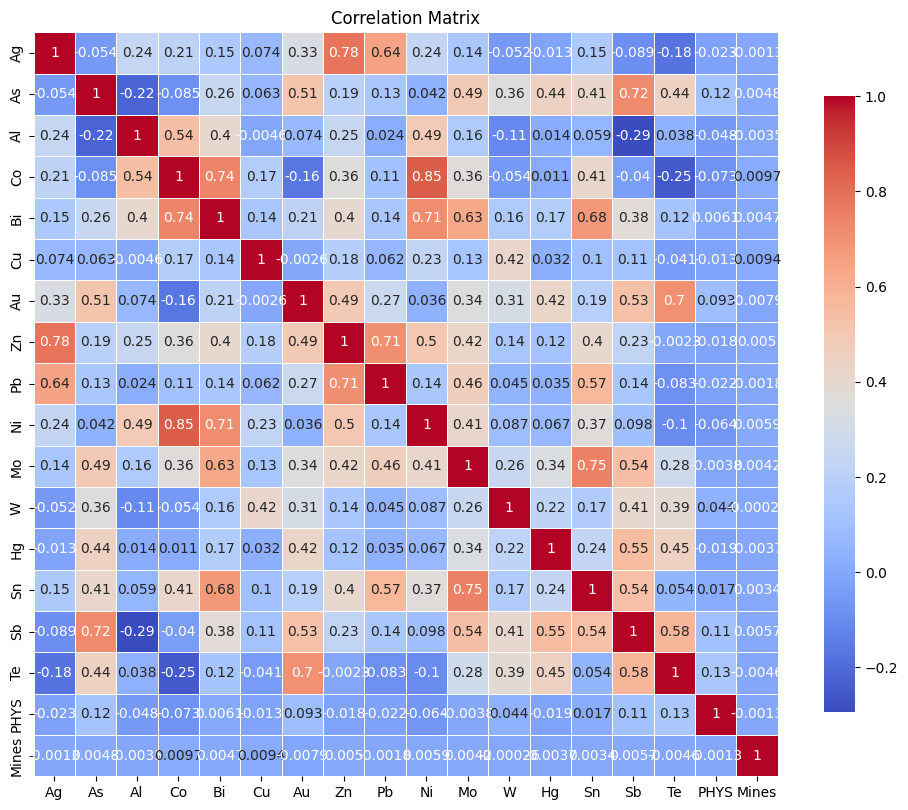

In [26]:
#Create a DataFrame from flattened raster data and gold raster data
df = pd.DataFrame(raster_data).T
df['Mines'] = gold_mines_labels.flatten()
# Calculate correlation matrix
correlation_matrix = df.corr()

element_names = ['Ag', 'As', 'Al', 'Co', 'Bi', 'Cu', 'Au', 'Zn', 'Pb', 'Ni', 'Mo', 'W', 'Hg', 'Sn', 'Sb', 'Te', "PHYS", 'Mines']
plt.figure(figsize=(12, 10))

sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            square=True,
            cbar_kws={'shrink': .8},
            annot_kws={"size": 10},
            linewidths=.5,
            xticklabels=element_names,
            yticklabels=element_names)

plt.title('Correlation Matrix')
plt.show()

In [27]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", padding='same', input_shape=(cnn_input.shape[0], cnn_input.shape[1], cnn_input.shape[2])),
    Conv2D(64, (3, 3), activation="relu", padding='same'),
    Conv2D(1, (3, 3), activation="sigmoid", padding='same')
])

#compile Model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

#reshape data for model input
cnn_input = cnn_input.reshape(1, cnn_input.shape[0], cnn_input.shape[1], cnn_input.shape[2])


gold_mine_labels = gold_mines_labels.reshape(1, gold_mines_labels.shape[0], gold_mines_labels.shape[1], 1)

#Train Model
model.fit(cnn_input, gold_mine_labels, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1447 - loss: 0.7154
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step - accuracy: 0.9823 - loss: 0.6738
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step - accuracy: 0.9990 - loss: 0.6338
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9997 - loss: 0.5922
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9997 - loss: 0.5470
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9997 - loss: 0.4965
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step - accuracy: 0.9997 - loss: 0.4402
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9997 - loss: 0.3788
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9997 - loss: 0.3159
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9997 - loss: 0.2556


In [28]:
predictions = model.predict(cnn_input)

predictions = predictions.reshape(gold_mines_labels.shape)

predictions = (predictions - np.min(predictions)) / (np.max(predictions) - np.min(predictions))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


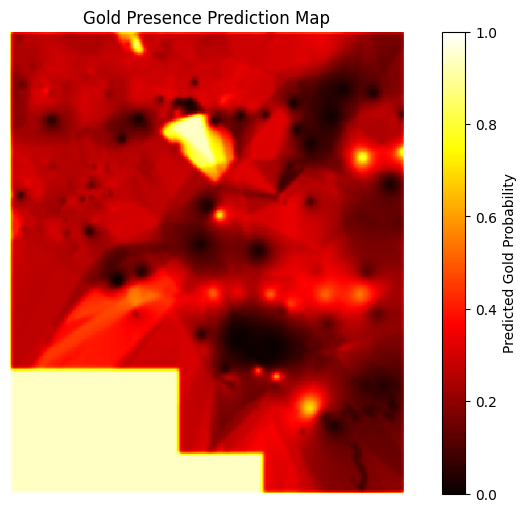

In [29]:
plt.figure(figsize=(10, 6))
plt.imshow(predictions, cmap="hot", interpolation="nearest")
plt.colorbar(label="Predicted Gold Probability")
plt.title("Gold Presence Prediction Map")
plt.axis("off")
plt.show()

In [31]:
#saving heatmap as raster for arc visualization
with rasterio.open(tif_files_and_Geophys[0]) as src:
    profile = src.profile

profile.update({
    'dtype': rasterio.float32,
    'count': 1
})

with rasterio.open("gold_presence_soil.tif", "w", **profile) as dst:
    dst.write(predictions.astype(rasterio.float32), 1)
print("Heatmap exported as gold_presence_heatmap.tif")

Heatmap exported as gold_presence_heatmap.tif


#Train Test Split

In [184]:
tif_files_and_Geophys = [
    'Data/Soil_Geochem/Soil_IDW_Ag/Soil_IDW_Ag.tif',  #Silver
    'Data/Soil_Geochem/Soil_IDW_As/Soil_IDW_As.tif',  #Arsenic
    'Data/Soil_Geochem/Soil_IDW_Al/Soil_IDW_Al.tif',  #Aluminum
    'Data/Soil_Geochem/Soil_IDW_Co/Soil_IDW_Co.tif',  #Cobalt
    'Data/Soil_Geochem/Soil_IDW_Bi/Soil_IDW_Bi.tif',  #Bismuth
    'Data/Soil_Geochem/Soil_IDW_Cu/Soil_IDW_Cu.tif',  #Copper
    'Data/Soil_Geochem/Soil_IDW_Au/Soil_IDW_Au.tif',  #Gold
    'Data/Soil_Geochem/Soil_IDW_Zn/Soil_IDW_Zn.tif',  #Zinc
    'Data/Soil_Geochem/Soil_IDW_Pb/Soil_IDW_Pb.tif',  #Lead
    'Data/Soil_Geochem/Soil_IDW_Ni/Soil_IDW_Ni.tif',  #Nickel
    'Data/Soil_Geochem/Soil_IDW_Mo/Soil_IDW_Mo.tif',  #Molybdenum
    'Data/Soil_Geochem/Soil_IDW_W/Soil_IDW_W.tif',    #Tungsten
    'Data/Soil_Geochem/Soil_IDW_Hg/Soil_IDW_Hg.tif',  #Mercury
    'Data/Soil_Geochem/Soil_IDW_Sn/Soil_IDW_Sn.tif',  #Tin
    'Data/Soil_Geochem/Soil_IDW_Sb/Soil_IDW_Sb.tif',  #Antimony
    'Data/Soil_Geochem/Soil_IDW_Te/Soil_IDW_Te.tif',  #Tellurium
    'Data/Geophysical_Anomaly/GeoPhysAnomaly_DONE.tif'
]

In [185]:
#setting label or target of model
with rasterio.open("Data/Gold_Litho/Litho_Gold.tif") as src:
    gold_mines_labels = src.read(1)
    transform = src.transform

In [186]:
cell_size = 0.1
width = src.width * transform.a
height = src.height * abs(transform.e)
xmin = transform.c
ymax = transform.f
xmax = xmin + width
ymin = ymax - height

x, y = np.meshgrid(np.arange(xmin, xmax, cell_size), np.arange(ymax, ymin, -cell_size))
x = x.flatten()
y = y.flatten()

grid = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(x, y)
).buffer(cell_size / 2, cap_style=3)

n_samples = len(grid)

n_train = int(n_samples * (1 - 0.2))
n_test = n_samples - n_train

train_grid = grid.sample(n=n_train, random_state=42)
test_grid = grid.drop(train_grid.index)

train_mask = rasterize(
    shapes=train_grid.geometry,
    out_shape=gold_mine_labels.shape[1:3],
    transform=transform,
    fill=0,
    default_value=1,
    dtype=rasterio.uint8,
)

test_mask = rasterize(
    shapes=test_grid.geometry,
    out_shape=gold_mine_labels.shape[1:3],
    transform=transform,
    fill=0,
    default_value=1,
    dtype=rasterio.uint8,
)

train_labels = gold_mine_labels.squeeze() * train_mask
test_labels = gold_mine_labels.squeeze() * test_mask

train_features_list = []
test_features_list = []

for tif_file in tif_files_and_Geophys:
    with rasterio.open(tif_file) as src:
        data = src.read(1)
        data = (data - np.min(data)) / (np.max(data) - np.min(data))  #Normalize 0-1

        train_data = data * train_mask
        test_data = data * test_mask

        train_features_list.append(train_data)
        test_features_list.append(test_data)

train_features = np.stack(train_features_list, axis=-1)
test_features = np.stack(test_features_list, axis=-1)

In [187]:
#reshape for inputs
train_features = train_features.reshape(1, train_features.shape[0], train_features.shape[1], train_features.shape[2])
train_labels = train_labels.reshape(1, train_labels.shape[0], train_labels.shape[1], 1)
test_features = test_features.reshape(1, test_features.shape[0], test_features.shape[1], test_features.shape[2])
test_labels = test_labels.reshape(1, test_labels.shape[0], test_labels.shape[1], 1)

# Adjust the input_shape argument in the first Conv2D layer
model = Sequential([
       Input(shape=(train_features.shape[1], train_features.shape[2], train_features.shape[3])),
       Conv2D(32, (3, 3), activation="relu", padding='same'),
       Dropout(0.2),
       Conv2D(64, (3, 3), activation="relu", padding='same'),
       Dropout(0.2),
       Conv2D(1, (3,3), activation='sigmoid', padding='same')
   ])

#compile Model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

model.fit(train_features, train_labels, epochs=10, validation_data=(test_features, test_labels))

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6969 - loss: 0.6827 - val_accuracy: 0.9866 - val_loss: 0.6750
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9787 - loss: 0.6375 - val_accuracy: 1.0000 - val_loss: 0.6577
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9988 - loss: 0.5901 - val_accuracy: 1.0000 - val_loss: 0.6384
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9998 - loss: 0.5406 - val_accuracy: 1.0000 - val_loss: 0.6171
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9998 - loss: 0.4882 - val_accuracy: 1.0000 - val_loss: 0.5935
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9998 - loss: 0.4344 - val_accuracy: 1.0000 - val_loss: 0.5678
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9998 - loss: 0.3797 - val_accuracy: 1.0000 - val_loss: 0.5399
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9998 - loss: 0.3262 - val_accuracy: 1.0000 - val_loss: 0.5104
Epoch 9/10
1/1 ━

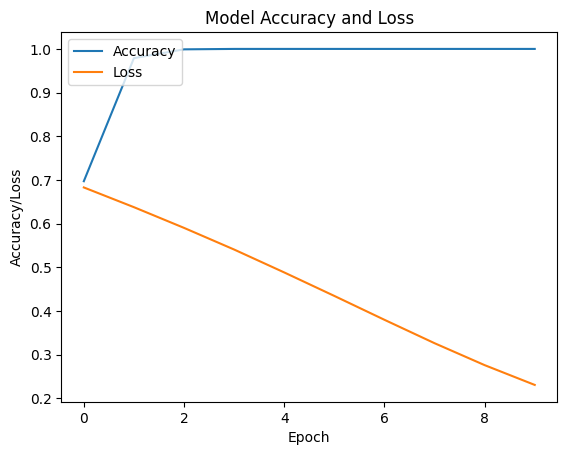

In [188]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['loss'])
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

In [189]:
predictions = model.predict(cnn_input)

predictions = predictions.reshape(gold_mines_labels.shape)

predictions = (predictions - np.min(predictions)) / (np.max(predictions) - np.min(predictions))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


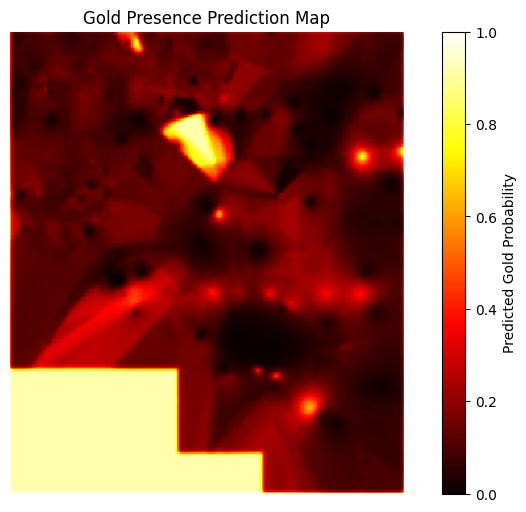

In [190]:
plt.figure(figsize=(10, 6))
plt.imshow(predictions, cmap="hot", interpolation="nearest")
plt.colorbar(label="Predicted Gold Probability")
plt.title("Gold Presence Prediction Map")
plt.axis("off")
plt.show()